<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/graph_based_prefiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet langchain langchain-community langchain-openai neo4j

In [2]:
import os
from typing import Dict, List, Optional, Tuple, Type

from langchain.agents import AgentExecutor
from langchain.agents.format_scratchpad import format_to_openai_function_messages
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser
from langchain.callbacks.manager import CallbackManagerForToolRun
from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain.tools import BaseTool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

from langchain_community.graphs import Neo4jGraph
from langchain_community.vectorstores import Neo4jVector
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars

# Graph-based metadata filtering for improving vector search in RAG applications
## Optimizing vector retrieval with advanced graph-based metadata techniques using LangChain and Neo4j
Text embeddings and vector similarity search help us find documents by understanding their meanings and how similar they are to each other. However, text embeddings aren't as effective when sorting information based on specific criteria like dates or categories; for example, if you need to find all documents created in a particular year or documents tagged under a specific category like "science fiction." This is where metadata filtering or filtered vector search comes into play, as it can effectively handle those structured filters, allowing users to narrow their search results according to specific attributes.

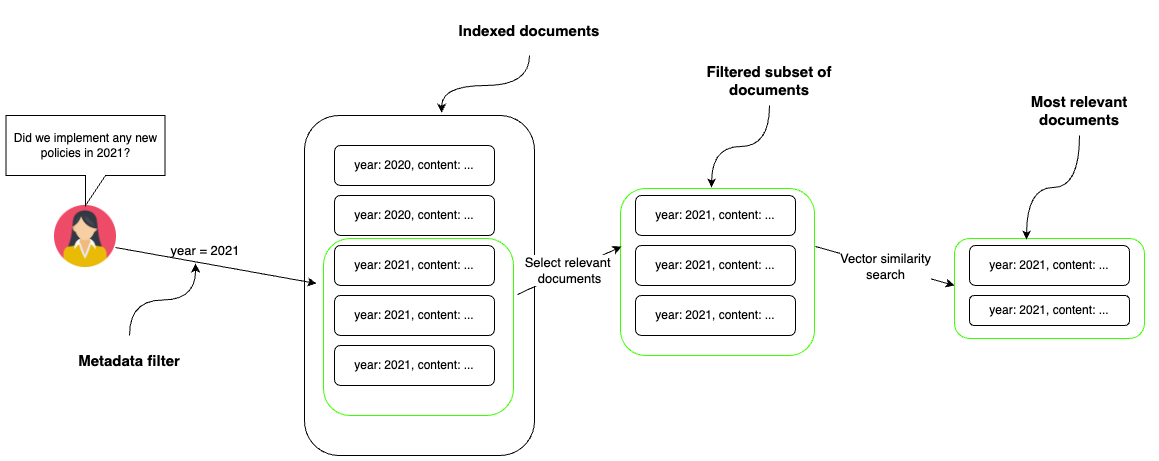


In the image provided, the process starts with a user asking whether any new policies were implemented in 2021. A metadata filter is then used to sort through a larger pool of indexed documents by the specified year, which in this case is 2021. This results in a filtered subset of documents from that year only. To further hone in on the most relevant documents, a vector similarity search is performed within this subset. This method allows the system to find documents closely related to the topic of interest from within the contextually relevant pool of documents from the year 2021. This two-step process, metadata filtering followed by vector similarity search, increases the accuracy and relevance of the search results.

Recently, we introduced [LangChain support for metadata filtering in Neo4j](https://python.langchain.com/docs/integrations/vectorstores/neo4jvector/#metadata-filtering) based on node properties. However, graph databases like Neo4j can store highly complex and connected structured data alongside unstructured data.

The unstructured part of the dataset represents articles and their text chunks. Text chunk nodes contain text and their text embedding values and are linked to the article nodes, where more information about the article, such as the date, sentiment, author, etc., is present. However, the articles are then further linked to the organizations they mention. In this example, the article mentions Neo4j. Additionally, our dataset includes a wealth of structured information about Neo4j such as its investors, board members, suppliers, and beyond.
Thus, we can leverage this extensive structured information to execute sophisticated metadata filtering, allowing us to precisely refine our document selection using structured criteria such as:
* Did any of the companies where Rod Johnson is the board member implement a new work-from-home policy?
* Are there any negative news about companies that Neo4j invested in?
* Were there any notable news in connection with supply chain problems for companies that supply Hyundai?

With all these example questions, you can greatly narrow down the relevant document subset using a structured graph-based metadata filter.
In this blog post, I will show you how to implement graph-based metadata filtering using LangChain in combination with OpenAI function-calling agent.
## Agenda
We will use the so-called companies graph dataset, available on a public demo server hosted by Neo4j.

The graph schema revolves around Organization nodes. There is vast information available regarding their suppliers, competitors, location, board members, and more. As mentioned before, there also articles mentioning particular organizations with their corresponding text chunks.
We will implement an OpenAI agent with a single tool, which can dynamically generate Cypher statements based on user input and retrieve relevant text chunks from the graph database. In this example, the tool will have four optional input parameters:
* topic: Any specific information or topic besides organization, country, and sentiment that the user is interested in.
* organization: Organization that the user wants to find information about
* country: Country of organizations that the user is interested in. Use full names like United States of America and France.
* sentiment: Sentiment of articles

Based on the four input parameters, we will dynamically, but deterministically, construct a corresponding Cypher statement to retrieve relevant information from the graph and use it as context to generate the final answer using an LLM.
You will require an OpenAI API key to follow along with the code.
## Function Implementation
We will begin by defining credentials and relevant connections to Neo4j.





In [3]:
import os

os.environ["OPENAI_API_KEY"] = "sk-"
os.environ["NEO4J_URI"] = "neo4j+s://demo.neo4jlabs.com"
os.environ["NEO4J_USERNAME"] = "companies"
os.environ["NEO4J_PASSWORD"] = "companies"
os.environ["NEO4J_DATABASE"] = "companies"

As mentioned, we will be using the OpenAI embeddings, for which you require their API key. Next, we define the graph connection to Neo4j, allowing us to execute arbitrary Cypher statements. Lastly, we instantiate a Neo4jVector connection, which can retrieve information by querying the existing vector index. At the time of writing this article, you cannot use the vector index in combination with the pre-filtering approach; you can only apply post-filtering in combination with the vector index. However, debating post-filtering is beyond the scope of this article as we will focus on pre-filtering approaches combined with an exhaustive vector similarity search.

In [4]:
embeddings = OpenAIEmbeddings()
graph = Neo4jGraph()
vector_index = Neo4jVector.from_existing_index(
    embeddings,
    index_name="news"
)

In [5]:
# Code for mapping organizations from user input to database using Full-text index
def generate_full_text_query(input: str) -> str:
    """
    Generate a full-text search query for a given input string.

    This function constructs a query string suitable for a full-text search.
    It processes the input string by splitting it into words and appending a
    similarity threshold (~0.8) to each word, then combines them using the AND
    operator. Useful for mapping movies and people from user questions
    to database values, and allows for some misspelings.
    """
    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el]
    for word in words[:-1]:
        full_text_query += f" {word}~2 AND"
    full_text_query += f" {words[-1]}~2"
    return full_text_query.strip()

candidate_query = """
CALL db.index.fulltext.queryNodes($index, $fulltextQuery, {limit: $limit})
YIELD node
WHERE node:Organization // Filter organization nodes
RETURN distinct node.name AS candidate
"""


def get_candidates(input: str, limit: int = 5) -> List[Dict[str, str]]:
    """
    Retrieve a list of candidate entities from database based on the input string.

    This function queries the Neo4j database using a full-text search. It takes the
    input string, generates a full-text query, and executes this query against the
    specified index in the database. The function returns a list of candidates
    matching the query.
    """
    ft_query = generate_full_text_query(input)
    candidates = graph.query(
        candidate_query, {"fulltextQuery": ft_query, "index": 'entity', "limit": limit}
    )
    # If there is direct match return only that, otherwise return all options
    direct_match = [el["candidate"] for el in candidates if el["candidate"].lower() == input.lower()]
    if direct_match:
        return direct_match

    return [el["candidate"] for el in candidates]

In [6]:
get_candidates("neo4")

['Net4', 'Neo4j', 'Neos', 'Neo', 'Neon Software']

More or less, the whole blog post boils down to the following get_organization_news function, which dynamically generates a Cypher statement and retrieves relevant information.

In [7]:
def get_organization_news(
    topic: Optional[str] = None,
    organization: Optional[str] = None,
    country: Optional[str] = None,
    sentiment: Optional[str] = None,
) -> str:
    # If there is no prefiltering, we can use vector index
    if topic and not organization and not country and not sentiment:
        return vector_index.similarity_search(topic)
    # Uses parallel runtime where available
    base_query = (
        "CYPHER runtime = parallel parallelRuntimeSupport=all "
        "MATCH (c:Chunk)<-[:HAS_CHUNK]-(a:Article) WHERE "
    )
    where_queries = []
    params = {"k": 5}  # Define the number of text chunks to retrieve
    if organization:
        # Map to database
        candidates = get_candidates(organization)
        if len(candidates) > 1:  # Ask for follow up if too many options
            return (
                "Ask a follow up question which of the available organizations "
                f"did the user mean. Available options: {candidates}"
            )
        where_queries.append(
            "EXISTS {(a)-[:MENTIONS]->(:Organization {name: $organization})}"
        )
        params["organization"] = candidates[0]
    if country:
        # No need to disambiguate
        where_queries.append(
            "EXISTS {(a)-[:MENTIONS]->(:Organization)-[:IN_CITY]->()-[:IN_COUNTRY]->(:Country {name: $country})}"
        )
        params["country"] = country

    if sentiment:
        if sentiment == "positive":
            where_queries.append("a.sentiment > $sentiment")
            params["sentiment"] = 0.5
        else:
            where_queries.append("a.sentiment < $sentiment")
            params["sentiment"] = -0.5
    if topic:  # Do vector comparison
        vector_snippet = (
            " WITH c, a, vector.similarity.cosine(c.embedding,$embedding) AS score "
            "ORDER BY score DESC LIMIT toInteger($k) "
        )
        params["embedding"] = embeddings.embed_query(topic)
        params["topic"] = topic
    else:  # Just return the latest data
        vector_snippet = " WITH c, a ORDER BY a.date DESC LIMIT toInteger($k) "

    return_snippet = "RETURN '#title ' + a.title + '\n#date ' + toString(a.date) + '\n#text ' + c.text AS output"

    complete_query = (
        base_query + " AND ".join(where_queries) + vector_snippet + return_snippet
    )
    data = graph.query(complete_query, params)
    print(f"Cypher: {complete_query}\n")
    # Safely remove embedding before printing
    params.pop('embedding', None)
    print(f"Parameters: {params}")
    return "###Article: ".join([el["output"] for el in data])


We begin by defining the input parameters. As you can observe, all of them are optional strings. The topic parameter is used to find specific information within documents. In practice, we embed the value of the topic parameter and use it as input for vector similarity search. The other three parameters will be used to demonstrate the pre-filtering approach.
If all of the pre-filtering parameters are empty, we can find the relevant documents using the existing vector index. Otherwise, we start preparing the base Cypher statement that will be used for the pre-filtered metadata approach. The clause `CYPHER runtime = parallel parallelRuntimeSupport=all` instructs the Neo4j database to use parallel runtime where available. Next, we prepare a match statement that selects `Chunk` nodes and their corresponding `Article` nodes.

Now we are ready to dynamically append metadata filters to the Cypher statement. We will begin with `Organization` filter.

If the LLM identifies any particular organization the user is interested in, we must first map the value to the database with the get_candidatesfunction. Under the hood, the `get_candidates` function uses keyword search utilizing a full-text index to find candidate nodes. If multiple candidates are found, we instruct the LLM to ask a follow-up question to the user to clarify which organization they meant exactly. Otherwise we append an existential subquery that filters the articles which mention the particular organization to the list of filters. To prevent any Cypher injection, we use query parameters instead of concatenating the query.

Next, we handle situations when a user wants to pre-filter text chunks based on the country of the mentioned organizations.

Since countries follow standard naming, we don't have to map values to the database, as LLMs are familiar with most country naming standards.
Similarly, we also handle sentiment metadata filtering.

We will instruct the LLM to only use two values for a `sentiment` input value, either positive or negative. We then map these two values to appropriate filter values.

We handle the `topic` parameter slightly differently as it's not used for prefiltering but rather vector similarity search.

If the LLM identifies that the user is interested in a particular topic in the news, we use the topic input's text embedding to find the most relevant documents. On the other hand, if no specific topic is identified, we simply return the latest couple of articles and avoid vector similarity search altogether.

Now, we have to put the Cypher statement together and use it to retrieve information from the database.

We construct the final complete_query by combining all the query snippets. After that, we use the dynamically generated Cypher statement to retrieve information from the database and return it to the LLM. Let's examine the generated Cypher statement for an example input.

In [8]:
get_organization_news(
    organization='neo4j',
    sentiment='positive',
    topic='remote work'
)

Cypher: CYPHER runtime = parallel parallelRuntimeSupport=all MATCH (c:Chunk)<-[:HAS_CHUNK]-(a:Article) WHERE EXISTS {(a)-[:MENTIONS]->(:Organization {name: $organization})} AND a.sentiment > $sentiment WITH c, a, vector.similarity.cosine(c.embedding,$embedding) AS score ORDER BY score DESC LIMIT toInteger($k) RETURN '#title ' + a.title + '
#date ' + toString(a.date) + '
#text ' + c.text AS output

Parameters: {'k': 5, 'organization': 'Neo4j', 'sentiment': 0.5, 'topic': 'remote work'}


'#title Accounts in Transit: Ruder Finn Adds Neo4j\n#date 2023-04-27T00:00:00Z\n#text Ruder Finn signs on as North American agency of record for Neo4j, a native graph database and analytics company. The agency will be responsible for implementing an integrated communications program, as well as working to amplify awareness of the company and category. The scope of work will include strategic media relations and executive communications to support corporate and product PR. Antonia Caamaño, SVP of RF Tech, will lead the Ruder Finn team handling the account out of New York. "We chose Ruder Finn to achieve our next stage of awareness because of the agency\'s experience in enterprise IT and deep tech, which allows them to deliver smart strategies and creative executions, as well as their long-running relationships with top-tier media,” said Neo4j CMO Chandra Rangan.\nOak Public Relations is named communications agency of record for Custom Cones USA, which produces supplies for cannabis pre-

The dynamic query generations works as expected, and is able to retrieve relevant information from the database.
## Defining OpenAI agent
Next, we need to wrap the function as an Agent tool. First, we will add input parameter descriptions.

In [9]:
fewshot_examples = """{Input:What are the health benefits for Google employees in the news? Topic: Health benefits}
{Input: What is the latest positive news about Google? Topic: None}
{Input: Are there any news about VertexAI regarding Google? Topic: VertexAI}
{Input: Are there any news about new products regarding Google? Topic: new products}
"""

class NewsInput(BaseModel):
    topic: Optional[str] = Field(
        description="Any particular topic that the user wants to finds information for. Here are some examples: "
        + fewshot_examples
    )
    organization: Optional[str] = Field(
        description="Organization that the user wants to find information about"
    )
    country: Optional[str] = Field(
        description="Country of organizations that the user is interested in. Use full names like United States of America and France."
    )
    sentiment: Optional[str] = Field(
        description="Sentiment of articles", enum=["positive", "negative"]
    )


The pre-filtering parameters were quite simple to describe, but I had some problems with getting the topic parameter to work as expected. In the end, I decided to add some examples so that the LLM would understand it better. Additionally, you can observe that we give the LLM information about the country naming format as well as provide enumeration for sentiment .
Now, we can define a custom tool by giving it a name and description containing instructions for an LLM on when to use it.

In [10]:
class NewsTool(BaseTool):
    name = "NewsInformation"
    description = (
        "useful for when you need to find relevant information in the news"
    )
    args_schema: Type[BaseModel] = NewsInput

    def _run(
        self,
        topic: Optional[str] = None,
        organization: Optional[str] = None,
        country: Optional[str] = None,
        sentiment: Optional[str] = None,
        run_manager: Optional[CallbackManagerForToolRun] = None,
    ) -> str:
        """Use the tool."""
        return get_organization_news(topic, organization, country, sentiment)

    async def _arun(
        self,
        topic: Optional[str] = None,
        organization: Optional[str] = None,
        country: Optional[str] = None,
        sentiment: Optional[str] = None,
        run_manager: Optional[CallbackManagerForToolRun] = None,
    ) -> str:
        """Use the tool asynchronously."""
        return get_organization_news(topic, organization, country, sentiment)

One last thing is to define the Agent executor. I just reuse the LCEL implementation of an OpenAI agent I implemented some time ago.

In [11]:
llm = ChatOpenAI(temperature=0, model="gpt-4-turbo", streaming=True)
tools = [NewsTool()]

llm_with_tools = llm.bind(functions=[convert_to_openai_function(t) for t in tools])

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that finds information about movies "
            " and recommends them. If tools require follow up questions, "
            "make sure to ask the user for clarification. Make sure to include any "
            "available options that need to be clarified in the follow up questions "
            "Do only the things the user specifically requested. ",
        ),
        MessagesPlaceholder(variable_name="chat_history"),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

def _format_chat_history(chat_history: List[Tuple[str, str]]):
    buffer = []
    for human, ai in chat_history:
        buffer.append(HumanMessage(content=human))
        buffer.append(AIMessage(content=ai))
    return buffer


agent = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: _format_chat_history(x["chat_history"])
        if x.get("chat_history")
        else [],
        "agent_scratchpad": lambda x: format_to_openai_function_messages(
            x["intermediate_steps"]
        ),
    }
    | prompt
    | llm_with_tools
    | OpenAIFunctionsAgentOutputParser()
)

agent_executor = AgentExecutor(agent=agent, tools=tools)

The agent has a single tool it can use to retrieve information about the news. We also added the `chat_history` message placeholder, making the agent conversational and allowing follow-up questions and replies.
## Implementation testing
Let's run a couple of inputs and examine the generated Cypher statements and parameters.

In [12]:
agent_executor.invoke({"input": "What are some positive news regarding neo4j?"})

Cypher: CYPHER runtime = parallel parallelRuntimeSupport=all MATCH (c:Chunk)<-[:HAS_CHUNK]-(a:Article) WHERE EXISTS {(a)-[:MENTIONS]->(:Organization {name: $organization})} AND a.sentiment > $sentiment WITH c, a ORDER BY a.date DESC LIMIT toInteger($k) RETURN '#title ' + a.title + '
#date ' + toString(a.date) + '
#text ' + c.text AS output

Parameters: {'k': 5, 'organization': 'Neo4j', 'sentiment': 0.5}


{'input': 'What are some positive news regarding neo4j?',
 'output': "Here are some positive news regarding Neo4j:\n\n1. **New Product Integrations with Generative AI Features in Google Cloud Vertex AI**:\n   - Neo4j announced a new product integration with Google Cloud's latest generative AI features in Vertex AI. This integration allows enterprise customers to use knowledge graphs built on Neo4j's cloud offerings in Google Cloud Platform for more accurate, transparent, and explainable generative AI insights and recommendations. This partnership, which began in 2019, has enabled various AI use cases across large enterprises and SMBs, ranging from anti-money laundering to personalized recommendations and more.\n\n2. **Recognition at the 2023 Graphie Awards in Australia and New Zealand**:\n   - During the 2023 GraphSummit Australia, Neo4j recognized organizations and individuals for outstanding innovation in implementing Neo4j’s graph technology. DXC Technology was awarded for its Excel

The generated Cypher statement is valid. Since we didn't specify any particular topic, it returns the last five text chunks from positive articles mentioning Neo4j. Let's something a bit more complex:

In [13]:
agent_executor.invoke({"input": "What are some of the latest negative news about employee happiness for companies from France?"})

Cypher: CYPHER runtime = parallel parallelRuntimeSupport=all MATCH (c:Chunk)<-[:HAS_CHUNK]-(a:Article) WHERE EXISTS {(a)-[:MENTIONS]->(:Organization)-[:IN_CITY]->()-[:IN_COUNTRY]->(:Country {name: $country})} AND a.sentiment < $sentiment WITH c, a, vector.similarity.cosine(c.embedding,$embedding) AS score ORDER BY score DESC LIMIT toInteger($k) RETURN '#title ' + a.title + '
#date ' + toString(a.date) + '
#text ' + c.text AS output

Parameters: {'k': 5, 'country': 'France', 'sentiment': -0.5, 'topic': 'employee happiness'}


{'input': 'What are some of the latest negative news about employee happiness for companies from France?',
 'output': 'Here are some of the latest negative news related to employee happiness for companies from France:\n\n1. **IBM Whistleblower Case**:\n   - **Date**: October 13, 2020\n   - **Summary**: IBM was ordered to pay £22,000 in compensation and two years\' salary to a British employee who blew the whistle on unlawful working practices within the company. The employee faced retaliation from managers after speaking up about conditions that potentially amounted to sex discrimination. The tribunal criticized IBM\'s managers for their lack of understanding of discrimination and the hostile work environment created for the whistleblower.\n\n2. **Manufacturing Business Leaders Resist Digital Progress**:\n   - **Date**: February 1, 2021\n   - **Summary**: A report titled "The Connected Enterprise" highlighted skepticism among manufacturing industry leaders in France regarding the benef

The LLM agent correctly generated prefiltering parameters but also identified a specific employee happiness topic. This topic is used as input to vector similarity search, allowing us to refine the retrieval process even more.
## Summary
In this blog post, we've implemented example graph-based metadata filters, enhancing vector search accuracy. However, the dataset has extensive and interconnected options that allow for much more sophisticated pre-filtering queries. With a graph data representation, the possibilities for structured filters are virtually limitless when combined with the LLM function-calling feature to generate Cypher statements dynamically.

Additionally, your agent could have tools that retrieve unstructured text, as shown in this blog post, as well as other tools that can retrieve structured information, making a knowledge graph an excellent solution for many RAG applications.